# Data Cleaning (Part 1)

The objective of this Python notebook is to clean the extracted scam reports. The data cleaning pipeline is as shown:

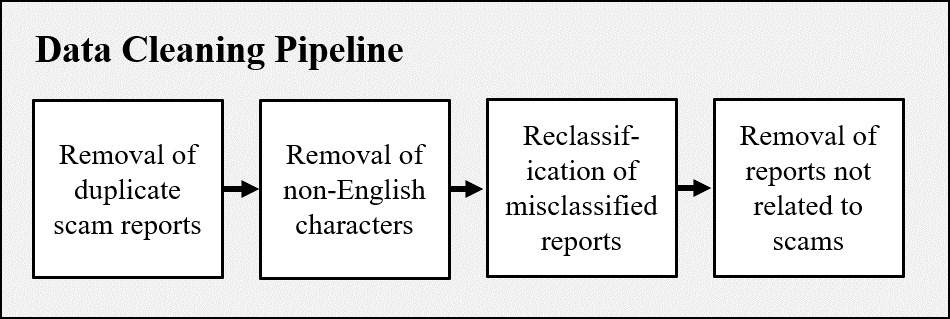

## Import the necessary libraries

In [1]:
import pandas as pd
import re
import random
import string
from datetime import datetime

## Define functions

In [4]:
def get_random_alphanumeric_string(stringLength=8):
    
    "This function generates random alphanumeric string of a specified length"
    
    lettersAndDigits = string.ascii_letters + string.digits
    
    return ''.join((random.choice(lettersAndDigits) for i in range(stringLength)))

## Load the dataset

In [3]:
scam_df = pd.read_csv("Data/scam_raw_dataset.csv").drop(columns=['Unnamed: 0'])
scam_df.head()

,submission_details,scam_type,incident_description,scammer_details
0,Anonymous | 17 Jul 2020,Impersonation Scam,\r\n They call me by whatsapp ...,\r\n Name: I only know ...
1,Anonymous | 17 Jul 2020,Phishing Scam,\r\n it happened this morning 0...,\r\n Name: Ministry of ...
2,Anonymous | 17 Jul 2020,Phishing Scam,\r\n I rceived a call from a la...,\r\n Name: SIngtel\r\n ...
3,Anonymous | 16 Jul 2020,Impersonation Scam,\r\n details: I received a call...,\r\n Name: Singapore hi...
4,Anonymous | 16 Jul 2020,Phishing Scam,\n1) An impersonated junior technical staff ca...,"\r\n Name: SINGTEL, RON..."


## Generation of unique IDs

For each row of observation, we will generate unique IDs in the following format:
- YYYYMMDD-XXXXXX, where XXXXXX is a random alphanumeric string consisting of lower and upper cases

In [9]:
# Extract date of submission
scam_df['submission_date'] = scam_df['submission_details'].str.split('|').str[1].str.strip()

# Convert date to datetime object
scam_df['date'] = scam_df.apply(lambda x: datetime.strptime(x['submission_date'], "%d %b %Y"), axis=1)

# Extract name of informant
scam_df['informant'] = scam_df['submission_details'].str.split('|').str[0].str.strip()

# Delete the original column
scam_df = scam_df.drop(columns=['submission_details', 'submission_date'])

# Sanity check
scam_df.head()

,scam_type,incident_description,scammer_details,date,informant
0,Impersonation Scam,\r\n They call me by whatsapp ...,\r\n Name: I only know ...,2020-07-17,Anonymous
1,Phishing Scam,\r\n it happened this morning 0...,\r\n Name: Ministry of ...,2020-07-17,Anonymous
2,Phishing Scam,\r\n I rceived a call from a la...,\r\n Name: SIngtel\r\n ...,2020-07-17,Anonymous
3,Impersonation Scam,\r\n details: I received a call...,\r\n Name: Singapore hi...,2020-07-16,Anonymous
4,Phishing Scam,\n1) An impersonated junior technical staff ca...,"\r\n Name: SINGTEL, RON...",2020-07-16,Anonymous


https://pynative.com/python-generate-random-string/

In [11]:
# Initialise a new column to store unique ID for each submission
scam_df = scam_df.assign(submission_id="")

# Define a random seed to generate the same unique ID everytime
random.seed(999)

# Loop through the dataset to generate unique ID for each submission
for i in range(len(scam_df)):
    scam_df.loc[i, 'submission_id'] = scam_df.loc[i, 'date'].strftime('%Y%m%d') + '-' + get_random_alphanumeric_string(6)

In [12]:
# Rearrange columns
scam_df = scam_df[['submission_id', 'date', 'informant', 'incident_description', 'scammer_details', 'scam_type']]

# Sanity check
scam_df.head()

,submission_id,date,informant,incident_description,scammer_details,scam_type
0,20200717-YRf53K,2020-07-17,Anonymous,\r\n They call me by whatsapp ...,\r\n Name: I only know ...,Impersonation Scam
1,20200717-KIFEi4,2020-07-17,Anonymous,\r\n it happened this morning 0...,\r\n Name: Ministry of ...,Phishing Scam
2,20200717-ZPuPYP,2020-07-17,Anonymous,\r\n I rceived a call from a la...,\r\n Name: SIngtel\r\n ...,Phishing Scam
3,20200716-20gP1m,2020-07-16,Anonymous,\r\n details: I received a call...,\r\n Name: Singapore hi...,Impersonation Scam
4,20200716-jqKdSX,2020-07-16,Anonymous,\n1) An impersonated junior technical staff ca...,"\r\n Name: SINGTEL, RON...",Phishing Scam


## Removal of duplicate scam reports

In [14]:
scam_df = scam_df.set_index('submission_id')

In [15]:
print("There are %d columns and %d rows in the scam_df dataset." % (len(scam_df.columns), len(scam_df)))

There are 5 columns and 4660 rows in the scam_df dataset.


In [16]:
print("Out of %d rows, %d are duplicates. We need to remove them." % (len(scam_df), len(scam_df[scam_df.duplicated()])))

Out of 4660 rows, 64 are duplicates. We need to remove them.


In [17]:
# Remove duplicate rows
scam_df = scam_df.drop_duplicates()

In [18]:
print("After removing duplicates, we are left with %d rows of unique records." % (len(scam_df)))

After removing duplicates, we are left with 4596 rows of unique records.


## Removal of Chinese characters

In [107]:
# Define regular expression for Chinese characters
chinese = '[\u2E80-\u2FD5\u3190-\u319f\u3400-\u4DBF\u4E00-\u9FCC\uF900-\uFAAD]'

# Create an empty list to store submission IDs of rows which contain Chinese characters
sub_id_chinese = []

# Loop through the rows of scam_df to extract the indices of rows where the incident description contains Chinese characters
for idx, row in enumerate(scam_df['incident_description']):
    if len(re.findall(chinese, row)) != 0:
        sub_id_chinese.append(scam_df.index[idx])

In [108]:
print("A total of %d rows contain Chinese characters. For a majority of them, Chinese characters were used only for a small segment of the text." % len(sub_id_chinese))

A total of 96 rows contain Chinese characters. For a majority of them, Chinese characters were used only for a small segment of the text.


We shall manually inspect each row which contain Chinese characters and record the corresponding submission IDs.

In [109]:
# Subset the dataframe for records containing Chinese characters
chinese_char_df = scam_df.loc[sub_id_chinese, :][['incident_description']].reset_index()
chinese_char_df = chinese_char_df.set_index('submission_id') 
chinese_char_df

,incident_description
submission_id,
20200614-9iRNZr,\r\n 在社交媒体认识的阿正.\n他称自己是学生，需要赚外快...
20200609-xsFm4i,\r\n was chatting with a guy me...
20200607-Rk2uFx,\nLadies/gentlman \n\nplease be careful when y...
20200529-cAHfXy,"\nI met this person online, he is from China s..."
20200422-IAbO6o,\r\n Matched with an overzealou...
...,...
20160828-kaOj4l,\r\n I found Xiao Yun on WeChat...
20160825-mN3lkk,\r\n I found (佳佳)JiaJia in Tind...
20160816-C9pjae,\r\n I received a call this mor...


In [117]:
# List of submission IDs where almost entire text is in Chinese characters
chinese_char_list = ['20200614-9iRNZr', '20200408-vo2984', '20191114-mHxkc9', '20181006-o89Jy9', '20180720-BO30aY', '20180617-mn4aLm']
print("Out of 96 scam stories with Chinese characters, only %d had almost the entire text in Chinese characters." % len(chinese_char_list))

Out of 96 scam stories with Chinese characters, only 6 had almost the entire text in Chinese characters.


Given that these stories make up a small proportion of all scam stories, we shall remove them.

In [118]:
# Remove rows where entire text is in Chinese characters
scam_df = scam_df.drop(chinese_char_list)

# Sanity check
scam_df.head()

,date,informant,incident_description,scammer_details,scam_type
submission_id,,,,,
20200717-fBLC6F,2020-07-17,Anonymous,\r\n They call me by whatsapp ...,\r\n Name: I only know ...,Impersonation Scam
20200717-yOxIAl,2020-07-17,Anonymous,\r\n it happened this morning 0...,\r\n Name: Ministry of ...,Phishing Scam
20200717-Tz5TyW,2020-07-17,Anonymous,\r\n I rceived a call from a la...,\r\n Name: SIngtel\r\n ...,Phishing Scam
20200716-O79B6r,2020-07-16,Anonymous,\r\n details: I received a call...,\r\n Name: Singapore hi...,Impersonation Scam
20200716-yIa3LH,2020-07-16,Anonymous,\n1) An impersonated junior technical staff ca...,"\r\n Name: SINGTEL, RON...",Phishing Scam


For the remaining 4590 records, Chinese characters occupy a small segment of the text (e.g. names of persons, organisations etc). Hence, we shall remove these characters.

In [120]:
# Loop through the dataset to remove all Chinese characters
for i in scam_df.index:
    if i in sub_id_chinese:
        a = scam_df.loc[i, 'incident_description']
        scam_df.loc[i, 'incident_description'] = re.sub(chinese, '', a)

In [121]:
# Sanity check for any remaining Chinese characters in the 'incident_description' column
for idx, row in enumerate(scam_df['incident_description']):
    if len(re.findall(chinese, row)) != 0:
        print('index: ', idx)

In [125]:
scam_df = scam_df.reset_index()

In [126]:
scam_df.head()

,submission_id,date,informant,incident_description,scammer_details,scam_type
0,20200717-fBLC6F,2020-07-17,Anonymous,\r\n They call me by whatsapp ...,\r\n Name: I only know ...,Impersonation Scam
1,20200717-yOxIAl,2020-07-17,Anonymous,\r\n it happened this morning 0...,\r\n Name: Ministry of ...,Phishing Scam
2,20200717-Tz5TyW,2020-07-17,Anonymous,\r\n I rceived a call from a la...,\r\n Name: SIngtel\r\n ...,Phishing Scam
3,20200716-O79B6r,2020-07-16,Anonymous,\r\n details: I received a call...,\r\n Name: Singapore hi...,Impersonation Scam
4,20200716-yIa3LH,2020-07-16,Anonymous,\n1) An impersonated junior technical staff ca...,"\r\n Name: SINGTEL, RON...",Phishing Scam


In [127]:
print("After removing duplicates and submissions with fully-Chinese text, there are %d columns and %d rows in the scam_df dataset." % (len(scam_df.columns), len(scam_df)))

After removing duplicates and submissions with fully-Chinese text, there are 6 columns and 4590 rows in the scam_df dataset.


## Save dataframe as a CSV file

In [128]:
# Save resulting dataframe as a CSV file
scam_df.to_csv('Data/scam_data_1.csv')